# Data Exploration

## Overview
This notebook performs data exploration and preprocessing for GOES images. The workflow includes data loading, quality control, temporal alignment.

Usando: ../data/datos_GOES/OR_ABI-L2-MCMIPF-M6_G16_s20243261340203_e20243261349524_c20243261350010.nc
Tensor (C,H,W): (16, 32, 32) | Timestamp UTC: 2024-11-21 13:40:20.300000+00:00


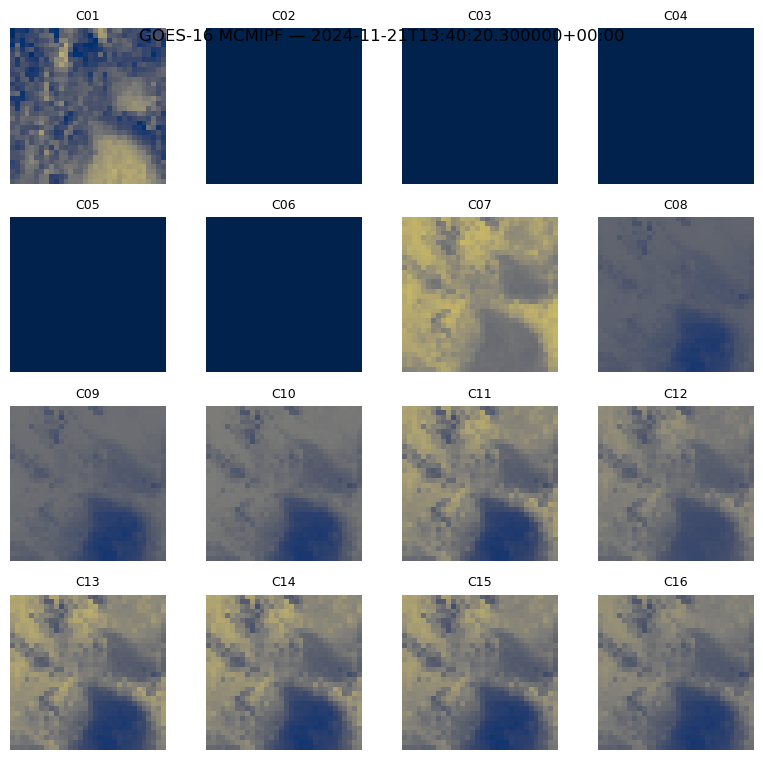

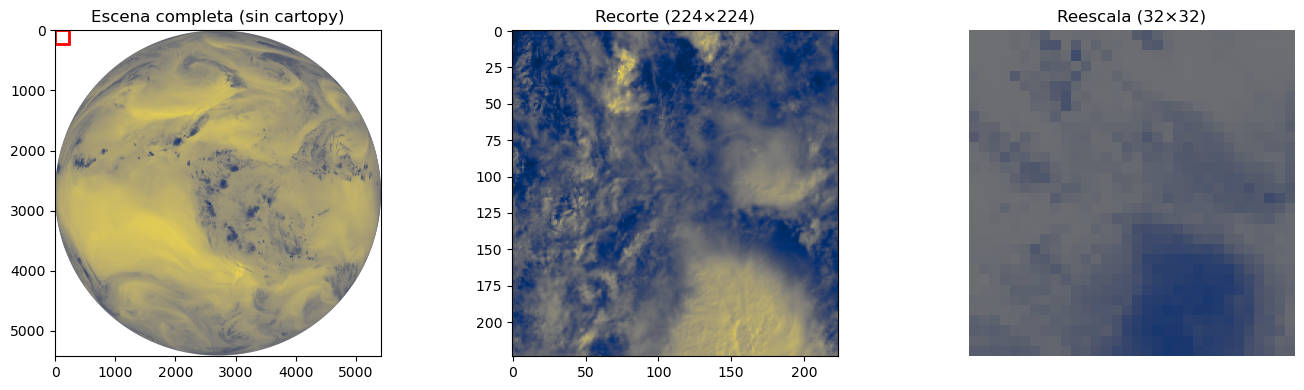

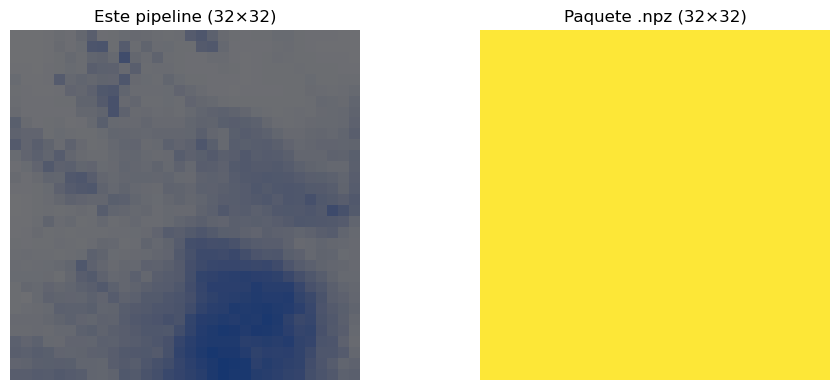

Máxima diferencia |NPZ - nuestro| (canal C09 norm): 244.9389
Guardado: ../data_interim/goes_demo/datos_sateli.pkl
Guardado Zarr: ../data_interim/goes_demo/goes_chw.zarr


In [2]:
# %% [markdown]
# # GOES-16 (MCMIPF) — Recorte centrado en Uniandes, validación y serie temporal
# Este notebook:
# 1) Lee un NetCDF (MCMIPF) y extrae un parche centrado en Uniandes (C01..C16).
# 2) Reescala a 32x32 sin OpenCV (scipy.ndimage.zoom) y normaliza (vis/IR).
# 3) Muestra una cuadrícula 4x4 de canales y, si hay cartopy, un mapa con la caja de recorte.
# 4) Compara contra tu `.npz` (si existe) y guarda una serie mínima en disco (Pickle / Zarr).

# %% [markdown]
# ## Librerías

from dataclasses import dataclass
from pathlib import Path
import numpy as np
import pandas as pd
import xarray as xr

import matplotlib.pyplot as plt
import matplotlib.patches as mpatches

from scipy.ndimage import zoom

# Dependencias opcionales para el mapa (cargan si están instaladas)
try:
    import cartopy.crs as ccrs
    import cartopy.feature as cfeature
    HAS_CARTOPY = True
except Exception:
    HAS_CARTOPY = False

# %% [markdown]
# ## Parámetros

@dataclass
class ROIConfig:
    lon: float = -74.0659   # Uniandes (ajusta si tienes las exactas)
    lat: float =  4.6043
    in_size_px: int = 224   # lado del recorte n×n (par)
    out_size_px: int = 32   # reescala final
    chans: tuple = tuple(range(1,17))  # C01..C16

cfg = ROIConfig()

# Ruta a un archivo MCMIPF para la demo (ajusta patrón/ruta)
NC_DEMO = "../data/datos_GOES/OR_ABI-L2-MCMIPF-M6_G16_s20243261340203_e20243261349524_c20243261350010.nc"

# (opcional) Dataset comprimido previo del grupo
NPZ_PATH = "../data/datos_GOES/datos_goes.npz"  # ajústalo a tu árbol real

# Directorios de salida
OUT_DIR = Path("../data_interim/goes_demo")
OUT_DIR.mkdir(parents=True, exist_ok=True)

# %% [markdown]
# ## Utilidades

def ensure_utc(ts_like) -> pd.Timestamp:
    """Devuelve un Timestamp tz-aware en UTC a partir de un string/ts."""
    ts = pd.Timestamp(ts_like)
    if ts.tz is None:
        return ts.tz_localize("UTC")
    return ts.tz_convert("UTC")

def resize_to(arr: np.ndarray, out_size: int) -> np.ndarray:
    """Reescala arr a out_size×out_size con bilinear (order=1)."""
    sy = out_size / arr.shape[0]
    sx = out_size / arr.shape[1]
    return zoom(arr, (sy, sx), order=1).astype("float32")

def normalize_channel(arr: np.ndarray, ch: int) -> np.ndarray:
    """Normaliza: visible → [0,1]; IR (180–330 K) → [0,1]."""
    a = arr.astype("float32")
    if ch == 1:  # visible
        return np.clip(a, 0, 1)
    # IR (brightness temperature)
    return (np.clip(a, 180, 330) - 180) / (330 - 180)

def geos_xy_for_lonlat(ds: xr.Dataset, lon: float, lat: float) -> tuple[float, float]:
    """
    Convierte (lon,lat) → coordenadas proyectadas (Xc, Yc) en metros del sistema GEOS del archivo.
    """
    import pyproj
    gip = ds["goes_imager_projection"]
    sat_h = float(gip.perspective_point_height)
    sat_lon = float(gip.longitude_of_projection_origin)
    sweep  = str(gip.sweep_angle_axis)

    geos = pyproj.CRS.from_proj4(f"+proj=geos +h={sat_h} +lon_0={sat_lon} +sweep={sweep} +ellps=WGS84")
    wgs84 = pyproj.CRS.from_epsg(4326)
    P = pyproj.Transformer.from_crs(wgs84, geos, always_xy=True)

    Xc, Yc = P.transform(lon, lat)  # metros en proyección GEOS
    return Xc, Yc

def crop_patch_from_nc(nc_path: str, channel: int, cfg: ROIConfig):
    """
    Carga CMI_Cxx, encuentra píxel más cercano a (lon,lat) y recorta un parche n×n (n=cfg.in_size_px).
    Devuelve:
      patch32 (32×32 normalizado), patch224 (crudo), extent_crop (xmin,xmax,ymin,ymax), ts_utc, x_full, y_full
    """
    ds = xr.open_dataset(nc_path)
    var = f"CMI_C{channel:02d}"
    if var not in ds.data_vars:
        ds.close()
        raise KeyError(f"{var} no está en {nc_path}")

    # Ejes x,y vienen en rad; multiplicar por altura satelital → metros
    x = ds["x"].values * float(ds["goes_imager_projection"].perspective_point_height)
    y = ds["y"].values * float(ds["goes_imager_projection"].perspective_point_height)

    # Tiempo
    ts_attr = (ds.attrs.get("t", None) or
               ds.attrs.get("time_coverage_start", None) or
               ds[var].attrs.get("time_coverage_start", None))
    ts_utc = ensure_utc(ts_attr) if ts_attr is not None else None

    # Centro (lon,lat) → (Xc,Yc)
    Xc, Yc = geos_xy_for_lonlat(ds, cfg.lon, cfg.lat)

    # Índices más cercanos
    ix = int(np.argmin((x - Xc)**2))
    iy = int(np.argmin((y - Yc)**2))

    half = cfg.in_size_px // 2
    xs = slice(max(ix - half, 0), min(ix + half, x.size))
    ys = slice(max(iy - half, 0), min(iy + half, y.size))

    # Recorte (y,x)
    patch = ds[var].isel(x=xs, y=ys).values  # numpy 2D
    ds.close()

    # Pad si tocamos borde
    ph, pw = patch.shape
    if (ph, pw) != (cfg.in_size_px, cfg.in_size_px):
        pad_y = max(0, cfg.in_size_px - ph)
        pad_x = max(0, cfg.in_size_px - pw)
        patch = np.pad(patch, ((0, pad_y), (0, pad_x)), mode="edge")

    # Extent del recorte (para mapa)
    x_crop = x[xs]
    y_crop = y[ys]
    extent_crop = (x_crop.min(), x_crop.max(), y_crop.min(), y_crop.max())

    # Reescala y normaliza
    patch32 = resize_to(patch, cfg.out_size_px)
    patch32 = normalize_channel(patch32, channel)

    return patch32, patch, extent_crop, ts_utc, x, y

def stack_channels(nc_path: str, cfg: ROIConfig):
    """Apila C01..C16 → tensor (C,H,W) normalizado + auxiliares del primer canal para graficar."""
    stacks = []
    first_meta = None
    for ch in cfg.chans:
        try:
            p32, p224, extent_crop, ts_utc, x_full, y_full = crop_patch_from_nc(nc_path, ch, cfg)
            stacks.append(p32)
            if first_meta is None:
                first_meta = dict(p224=p224, extent_crop=extent_crop, ts_utc=ts_utc,
                                  x_full=x_full, y_full=y_full)
        except Exception as e:
            # Si falta canal, rellena con NaN
            stacks.append(np.full((cfg.out_size_px, cfg.out_size_px), np.nan, dtype="float32"))
    X = np.stack(stacks, axis=0)  # (C,32,32)
    return X, first_meta

# %% [markdown]
# ## Demo de un archivo

from glob import glob

# Elige el archivo de demo (ajusta patrón si es necesario)
files = sorted(glob(NC_DEMO))
assert len(files) >= 1, "No se encontró el NetCDF de demo; ajusta NC_DEMO."
nc_path = files[0]
print("Usando:", nc_path)

# Extrae y apila canales
X, meta = stack_channels(nc_path, cfg)
ts = meta["ts_utc"]
print("Tensor (C,H,W):", X.shape, "| Timestamp UTC:", ts)

# %% [markdown]
# ### Visual: cuadrícula de canales (normalizados)

fig, axes = plt.subplots(4, 4, figsize=(8, 8))
for i, ax in enumerate(axes.ravel(), start=1):
    ax.imshow(X[i-1], vmin=0, vmax=1, cmap="cividis")
    ax.set_title(f"C{i:02d}", fontsize=9)
    ax.axis("off")
fig.suptitle(f"GOES-16 MCMIPF — {ts.isoformat()}", y=0.92)
fig.tight_layout()
plt.show()

# %% [markdown]
# ### Visual: imagen completa + caja de recorte + recorte (sin OpenCV)

# Para la figura de "full scene", usamos el canal 09 original (p224) si está en meta
p224 = meta["p224"]
extent_crop = meta["extent_crop"]
x_full = meta["x_full"]
y_full = meta["y_full"]

# Para imitar tu figura, necesitamos el canal 09 raw desde el archivo:
with xr.open_dataset(nc_path) as ds:
    if "CMI_C09" in ds:
        full_c09 = ds["CMI_C09"].values
    else:
        # Si no está C09, usa el primer canal disponible sólo para ilustrar
        full_c09 = ds[list(ds.data_vars)[0]].values

# Rectángulo en coords de proyección
xmin, xmax, ymin, ymax = extent_crop

if HAS_CARTOPY:
    gip = xr.open_dataset(nc_path)["goes_imager_projection"]
    sat_h = float(gip.perspective_point_height)
    central_lon = float(gip.longitude_of_projection_origin)
    sweep = str(gip.sweep_angle_axis)

    proj = ccrs.Geostationary(central_longitude=central_lon,
                              satellite_height=sat_h,
                              sweep_axis=sweep)
    fig = plt.figure(figsize=(14, 4))
    # 1) Full
    ax1 = fig.add_subplot(1,3,1, projection=proj)
    ax1.imshow(full_c09, extent=(x_full.min(), x_full.max(), y_full.min(), y_full.max()),
               transform=proj, origin="upper", vmin=np.nanpercentile(full_c09,5),
               vmax=np.nanpercentile(full_c09,95), cmap="cividis")
    ax1.add_feature(cfeature.COASTLINE, linewidth=0.8)
    ax1.add_feature(cfeature.BORDERS, linewidth=0.6)
    ax1.add_patch(mpatches.Rectangle((xmin,ymin), xmax-xmin, ymax-ymin,
                                     fill=False, edgecolor="red", linewidth=2, transform=proj))
    ax1.set_title("Escena completa + ROI", fontsize=11)

    # 2) Recorte 224×224 en proyección
    ax2 = fig.add_subplot(1,3,2, projection=proj)
    ax2.imshow(p224, extent=(xmin, xmax, ymin, ymax),
               transform=proj, origin="upper", cmap="cividis")
    ax2.set_title("Recorte (224×224)", fontsize=11)

    # 3) Reescalado 32×32
    ax3 = fig.add_subplot(1,3,3)
    ax3.imshow(X[8] if X.shape[0] >= 9 else X[0], cmap="cividis", vmin=0, vmax=1)  # C09 si existe
    ax3.set_title("Reescala (32×32)", fontsize=11)
    ax3.axis("off")
    plt.tight_layout(); plt.show()
else:
    # Sin cartopy: plot simple con rectángulo en píxeles relativos
    fig, (ax1, ax2, ax3) = plt.subplots(1,3, figsize=(14,4))
    ax1.imshow(full_c09, cmap="cividis")
    ax1.add_patch(mpatches.Rectangle((0,0), p224.shape[1], p224.shape[0],
                                     fill=False, edgecolor="red", linewidth=2))
    ax1.set_title("Escena completa (sin cartopy)")
    ax2.imshow(p224, cmap="cividis"); ax2.set_title("Recorte (224×224)")
    ax3.imshow(X[8] if X.shape[0] >= 9 else X[0], cmap="cividis", vmin=0, vmax=1)
    ax3.set_title("Reescala (32×32)"); ax3.axis("off")
    plt.tight_layout(); plt.show()

# %% [markdown]
# ## Comparación con `.npz` del grupo (si existe)

if Path(NPZ_PATH).exists():
    pack = np.load(NPZ_PATH, allow_pickle=True)
    timestamps = pd.to_datetime(pack["timestamps"])
    # Asegura tz-aware en UTC
    timestamps = pd.DatetimeIndex([ensure_utc(t) for t in timestamps])
    images = pack["images"]  # (T, C, 32, 32) según tu descripción

    # Busca el índice más cercano a ts
    i = int(np.argmin(np.abs(timestamps - ts)))
    ch_vis = 8  # canal 9 → índice 8 si 0-based
    arr_npz = images[i, ch_vis]  # (32,32)
    arr_new = X[ch_vis] if X.shape[0] > ch_vis else X[0]

    # Visual lado a lado
    fig2 = plt.figure(figsize=(10, 4))
    ax1 = fig2.add_subplot(1,2,1); ax1.imshow(arr_new, vmin=0, vmax=1, cmap="cividis")
    ax1.set_title("Este pipeline (32×32)"); ax1.axis("off")
    ax2 = fig2.add_subplot(1,2,2); ax2.imshow(arr_npz, vmin=0, vmax=1, cmap="cividis")
    ax2.set_title("Paquete .npz (32×32)"); ax2.axis("off")
    plt.tight_layout(); plt.show()

    # Diferencia máxima (escala normalizada)
    diff = np.nanmax(np.abs(arr_npz - arr_new))
    print(f"Máxima diferencia |NPZ - nuestro| (canal C09 norm): {diff:.4f}")
else:
    print("No se encontró NPZ_PATH; omito comparación.")

# %% [markdown]
# ## Construir una serie mínima y guardar
# (Para producción, recomiendo Zarr; aquí guardo un Pickle manteniendo compatibilidad con tu flujo.)

ts_idx = pd.DatetimeIndex([ts], name="time")
# DataFrame con arrays por canal (igual que tu ejemplo, pero con nombres '1'..'16')
data = {f"{i}": [X[i-1] if i-1 < X.shape[0] else np.full((cfg.out_size_px,cfg.out_size_px), np.nan, np.float32)]
        for i in range(1,17)}
df_one = pd.DataFrame(data, index=ts_idx)

# Unir a rejilla de 10 min (ejemplo: año del timestamp)
fecha_inicial = pd.Timestamp(f"{ts.year}-01-01 00:00:00", tz="UTC")
fecha_final   = pd.Timestamp(f"{ts.year}-12-31 23:50:00", tz="UTC")
rango = pd.date_range(fecha_inicial, fecha_final, freq="10min", tz="UTC")

fechas_horas = pd.DataFrame(index=rango)
df_join = pd.concat([fechas_horas, df_one], axis=1).reindex(fechas_horas.index)

# Guarda Pickle
OUT_PKL = OUT_DIR / "datos_sateli.pkl"
df_join.to_pickle(OUT_PKL)
print("Guardado:", OUT_PKL)

# Zarr (más eficiente para batches grandes)
try:
    import zarr, json
    Z = zarr.open(str(OUT_DIR / "goes_chw.zarr"), mode="w",
                  shape=(1, X.shape[0], X.shape[1], X.shape[2]),
                  chunks=(1, X.shape[0], X.shape[1], X.shape[2]),
                  dtype="f4")
    Z[0] = X
    (OUT_DIR / "times.json").write_text(json.dumps([ts.isoformat()]))
    print("Guardado Zarr:", OUT_DIR / "goes_chw.zarr")
except Exception as e:
    print("No se guardó Zarr (opcional):", e)
